In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession

import pandas 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import * 

spark = SparkSession.builder.appName('Info_722').getOrCreate()


In [7]:
dfacc = spark.read.load("./Accidents_2016.csv",format="csv",header="true")
dfacc.columns
#dfacc.count()
#print(len(dfacc.columns))

['Accident_Index',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Longitude',
 'Latitude',
 'Police_Force',
 'Accident_Severity',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Date',
 'Day_of_Week',
 'Time',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 '1st_Road_Number',
 'Road_Type',
 'Speed_limit',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 '2nd_Road_Number',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'LSOA_of_Accident_Location']

In [8]:
dfcas = spark.read.load("./Cas.csv",format="csv",header="true")
dfcas.columns
#dfcas.count()
#print(len(dfcas.columns))

['Accident_Index',
 'Vehicle_Reference',
 'Casualty_Reference',
 'Casualty_Class',
 'Sex_of_Casualty',
 'Age_of_Casualty',
 'Age_Band_of_Casualty',
 'Casualty_Severity',
 'Pedestrian_Location',
 'Pedestrian_Movement',
 'Car_Passenger',
 'Bus_or_Coach_Passenger',
 'Pedestrian_Road_Maintenance_Worker',
 'Casualty_Type',
 'Casualty_Home_Area_Type',
 'Casualty_IMD_Decile']

In [9]:
dfacc.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Location_Easting_OSGR: string (nullable = true)
 |-- Location_Northing_OSGR: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Police_Force: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Number_of_Vehicles: string (nullable = true)
 |-- Number_of_Casualties: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Local_Authority_(District): string (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: string (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_limit: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Numb

In [10]:
dfcas.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Vehicle_Reference: string (nullable = true)
 |-- Casualty_Reference: string (nullable = true)
 |-- Casualty_Class: string (nullable = true)
 |-- Sex_of_Casualty: string (nullable = true)
 |-- Age_of_Casualty: string (nullable = true)
 |-- Age_Band_of_Casualty: string (nullable = true)
 |-- Casualty_Severity: string (nullable = true)
 |-- Pedestrian_Location: string (nullable = true)
 |-- Pedestrian_Movement: string (nullable = true)
 |-- Car_Passenger: string (nullable = true)
 |-- Bus_or_Coach_Passenger: string (nullable = true)
 |-- Pedestrian_Road_Maintenance_Worker: string (nullable = true)
 |-- Casualty_Type: string (nullable = true)
 |-- Casualty_Home_Area_Type: string (nullable = true)
 |-- Casualty_IMD_Decile: string (nullable = true)



In [12]:
# 2.4 verified data quality

dfacc.count()

136621

In [13]:
dfacc.na.drop().count()

128268

In [14]:
dfcas.count()

181384

In [15]:
dfcas.na.drop().count()

181384

In [16]:
  #outlier detect & 3.5 reformat data

from pyspark.sql.types import DoubleType

for t in ['Location_Easting_OSGR','Location_Northing_OSGR','Longitude','Latitude','Number_of_Vehicles',
          'Number_of_Casualties','Day_of_Week','Local_Authority_(District)','1st_Road_Number','Speed_limit',
          'Junction_Detail','Junction_Control','2nd_Road_Number','Did_Police_Officer_Attend_Scene_of_Accident']:
    dfacc = dfacc.withColumn(t, dfacc[t].cast(DoubleType()))

dfacc_outlier = dfacc.select('Location_Easting_OSGR','Location_Northing_OSGR','Longitude','Latitude',
                             'Number_of_Vehicles','Number_of_Casualties','Day_of_Week','Local_Authority_(District)',
                             '1st_Road_Number','Speed_limit','Junction_Detail','Junction_Control','2nd_Road_Number',
                             'Did_Police_Officer_Attend_Scene_of_Accident')

dfacc_outlier.printSchema()

dfacc_outlier = dfacc_outlier.toPandas()

Q1 = dfacc_outlier.quantile(0.1)
Q3 = dfacc_outlier.quantile(0.9)
IQR = Q3 - Q1
print(((dfacc_outlier < (Q1 - 1.5 * IQR)) | (dfacc_outlier > (Q3 + 1.5 * IQR))).sum())


root
 |-- Location_Easting_OSGR: double (nullable = true)
 |-- Location_Northing_OSGR: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Number_of_Vehicles: double (nullable = true)
 |-- Number_of_Casualties: double (nullable = true)
 |-- Day_of_Week: double (nullable = true)
 |-- Local_Authority_(District): double (nullable = true)
 |-- 1st_Road_Number: double (nullable = true)
 |-- Speed_limit: double (nullable = true)
 |-- Junction_Detail: double (nullable = true)
 |-- Junction_Control: double (nullable = true)
 |-- 2nd_Road_Number: double (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: double (nullable = true)

Location_Easting_OSGR                             0
Location_Northing_OSGR                           26
Longitude                                         0
Latitude                                         26
Number_of_Vehicles                              122
Number_of_Casualties                

In [17]:

for t in ['Casualty_Reference','Age_of_Casualty','Age_Band_of_Casualty','Pedestrian_Road_Maintenance_Worker']:
    dfcas = dfcas.withColumn(t, dfcas[t].cast(DoubleType()))
dfcas_outlier = dfcas.select('Casualty_Reference','Age_of_Casualty','Age_Band_of_Casualty',
                             'Pedestrian_Road_Maintenance_Worker')

dfcas_outlier.printSchema()

dfcas_outlier = dfcas_outlier.toPandas()

Q1 = dfcas_outlier.quantile(0.1)
Q3 = dfcas_outlier.quantile(0.9)
IQR = Q3 - Q1
print(((dfcas_outlier < (Q1 - 1.5 * IQR)) | (dfcas_outlier > (Q3 + 1.5 * IQR))).sum())


root
 |-- Casualty_Reference: double (nullable = true)
 |-- Age_of_Casualty: double (nullable = true)
 |-- Age_Band_of_Casualty: double (nullable = true)
 |-- Pedestrian_Road_Maintenance_Worker: double (nullable = true)

Casualty_Reference                    5965
Age_of_Casualty                          0
Age_Band_of_Casualty                     0
Pedestrian_Road_Maintenance_Worker    6605
dtype: int64


In [18]:
# 3.1 select
dfacc_sele = dfacc.select('Accident_Index','Longitude','Latitude','Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 
                     'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', '1st_Road_Class', 'Road_Type', 'Speed_limit', 
                     'Junction_Detail', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 
                     'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 
                     'Carriageway_Hazards', 'Urban_or_Rural_Area')
dfacc_sele.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Number_of_Vehicles: double (nullable = true)
 |-- Number_of_Casualties: double (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: double (nullable = true)
 |-- Time: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_limit: double (nullable = true)
 |-- Junction_Detail: double (nullable = true)
 |-- Pedestrian_Crossing-Human_Control: string (nullable = true)
 |-- Pedestrian_Crossing-Physical_Facilities: string (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Weather_Conditions: string (nullable = true)
 |-- Road_Surface_Conditions: string (nullable = true)
 |-- Special_Conditions_at_Site: string (nullable = true)
 |-- Carriageway_Hazards: string (

In [19]:
dfcas_sele = dfcas.select('Accident_Index', 'Vehicle_Reference','Casualty_Class', 'Sex_of_Casualty', 'Age_of_Casualty',
              'Pedestrian_Location','Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Casualty_Type')

dfcas_sele.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Vehicle_Reference: string (nullable = true)
 |-- Casualty_Class: string (nullable = true)
 |-- Sex_of_Casualty: string (nullable = true)
 |-- Age_of_Casualty: double (nullable = true)
 |-- Pedestrian_Location: string (nullable = true)
 |-- Pedestrian_Movement: string (nullable = true)
 |-- Car_Passenger: string (nullable = true)
 |-- Bus_or_Coach_Passenger: string (nullable = true)
 |-- Casualty_Type: string (nullable = true)



In [20]:
# 3.2 clean Accident_2016 null
before = dfacc_sele.count()
dfacc_sele_after = dfacc_sele.na.drop()
after = dfacc_sele_after.count()

check_before = dfacc_sele_after.count()
check_after = dfacc_sele_after.na.drop()
check_after = check_after.count()
print((before,after),(check_before,check_after))

(136621, 136575) (136575, 136575)


In [21]:
before = dfcas_sele.count()
dfcas_sele_after = dfcas_sele.na.drop()
after = dfcas_sele_after.count()
print(before,after)

181384 181384


In [22]:
remove_outlier = dfacc_sele_after.toPandas()

filt_acciSub = remove_outlier[['Latitude','Number_of_Vehicles','Number_of_Casualties']]
Q1L = filt_acciSub['Latitude'].quantile(0.1)
Q3L = filt_acciSub['Latitude'].quantile(0.9)
IQRL = Q3L - Q1L
lowL = Q1L - 1.5 * IQRL
highL = Q3L + 1.5 * IQRL
remove_outlier = remove_outlier[(remove_outlier['Latitude']>lowL)&(remove_outlier['Latitude']<highL)]

Q1V = filt_acciSub['Number_of_Vehicles'].quantile(0.1)
Q3V = filt_acciSub['Number_of_Vehicles'].quantile(0.9)
IQRV = Q3V - Q1V
lowV = Q1V - 1.5 * IQRV
highV = Q3V + 1.5 * IQRV
remove_outlier = remove_outlier[(remove_outlier['Number_of_Vehicles']>lowV)&
                                (remove_outlier['Number_of_Vehicles']<highV)]

Q1C = filt_acciSub['Number_of_Casualties'].quantile(0.1)
Q3C = filt_acciSub['Number_of_Casualties'].quantile(0.9)
IQRC = Q3C - Q1C
lowC = Q1C - 1.5 * IQRC
highC = Q3C + 1.5 * IQRC
remove_outlier = remove_outlier[(remove_outlier['Number_of_Casualties']>lowC)&
                                (remove_outlier['Number_of_Casualties']<highC)]

filt_acciSub = remove_outlier[['Latitude','Number_of_Vehicles','Number_of_Casualties','Day_of_Week','Speed_limit']]
Q11 = filt_acciSub.quantile(0.1)
Q33 = filt_acciSub.quantile(0.9)
IQR = Q33 - Q11

print(((filt_acciSub < (Q11 - 1.5 * IQR)) | (filt_acciSub > (Q33 + 1.5 * IQR))).sum())

Latitude                   0
Number_of_Vehicles      2554
Number_of_Casualties       0
Day_of_Week                0
Speed_limit                0
dtype: int64


In [23]:
# exported file has been included in repository
#remove_outlier.to_csv("./remove_outlier.csv",index=False)

In [2]:
# 3.3 construct data
from pyspark.sql.functions import *

dfacc_sele_after = spark.read.load("./remove_outlier.csv",format="csv",header="true")
dfacc_sele_after = dfacc_sele_after.withColumn('Time',hour(dfacc_sele_after.Time))
dfacc_sele_after=dfacc_sele_after.withColumn('Time_period', when((col('Time') <= 4) & (col('Time') >= 0), '1').
                            otherwise( when((col('Time') <= 8) & (col('Time') > 4), '2').
                            otherwise( when((col('Time') <= 12) & (col('Time') >= 8), '3').
                            otherwise( when((col('Time') <= 16) & (col('Time') >= 12), '4').
                            otherwise( when((col('Time') <= 20) & (col('Time') >= 16), '5').
                            otherwise('6'))))))

dfacc_sele_after.select('Time_period').show()

+-----------+
|Time_period|
+-----------+
|          1|
|          1|
|          1|
|          3|
|          2|
|          3|
|          2|
|          3|
|          3|
|          3|
|          3|
|          3|
|          2|
|          2|
|          3|
|          2|
|          3|
|          2|
|          2|
|          4|
+-----------+
only showing top 20 rows



In [3]:
# two exported files has been included in the repository
#dfacc_sele_after.toPandas().to_csv('dfacc_sele.csv',index=False)
#dfcas_sele_after.toPandas().to_csv('dfcas_sele.csv',index=False)

NameError: name 'dfcas_sele_after' is not defined

In [19]:
# 3.4 Integrate data
acc_m = pandas.read_csv("./dfacc_sele.csv")
cas_m = pandas.read_csv("./dfcas_sele.csv")

merged = acc_m.merge(cas_m, on='Accident_Index', how="inner")
print(merged.columns)

print(merged.info())


Index(['Accident_Index', 'Longitude', 'Latitude', 'Police_Force',
       'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
       'Date', 'Day_of_Week', 'Time', '1st_Road_Class', 'Road_Type',
       'Speed_limit', 'Junction_Detail', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Time_period', 'Vehicle_Reference',
       'Casualty_Class', 'Sex_of_Casualty', 'Age_of_Casualty',
       'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger',
       'Bus_or_Coach_Passenger', 'Casualty_Type'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 165329 entries, 0 to 165328
Data columns (total 32 columns):
Accident_Index                             165329 non-null object
Longitude                                  165329 non-null float64
Latitude   

In [20]:
# 4.1 reduce the data
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
encoded_value = le.fit_transform([])

merged['Accident_Severity'] = le.fit_transform(merged['Accident_Severity'])
merged['1st_Road_Class'] = le.fit_transform(merged['1st_Road_Class'])
merged['Road_Type'] = le.fit_transform(merged['Road_Type'])
merged['Pedestrian_Crossing-Human_Control'] = le.fit_transform(merged['Pedestrian_Crossing-Human_Control'])
merged['Pedestrian_Crossing-Physical_Facilities'] = le.fit_transform(merged['Pedestrian_Crossing-Physical_Facilities'])
merged['Light_Conditions'] = le.fit_transform(merged['Light_Conditions'])
merged['Weather_Conditions'] = le.fit_transform(merged['Weather_Conditions'])
merged['Road_Surface_Conditions'] = le.fit_transform(merged['Road_Surface_Conditions'])
merged['Special_Conditions_at_Site'] = le.fit_transform(merged['Special_Conditions_at_Site'])
merged['Carriageway_Hazards'] = le.fit_transform(merged['Carriageway_Hazards'])
merged['Urban_or_Rural_Area'] = le.fit_transform(merged['Urban_or_Rural_Area'])
merged['Vehicle_Reference'] = le.fit_transform(merged['Vehicle_Reference'])
merged['Casualty_Class'] = le.fit_transform(merged['Casualty_Class'])
merged['Sex_of_Casualty'] = le.fit_transform(merged['Sex_of_Casualty'])
merged['Pedestrian_Location'] = le.fit_transform(merged['Pedestrian_Location'])
merged['Pedestrian_Movement'] = le.fit_transform(merged['Pedestrian_Movement'])
merged['Car_Passenger'] = le.fit_transform(merged['Car_Passenger'])
merged['Bus_or_Coach_Passenger'] = le.fit_transform(merged['Bus_or_Coach_Passenger'])
merged['Casualty_Type'] = le.fit_transform(merged['Casualty_Type'])

merged['Age_of_Casualty'].replace(-1,0).describe()
merged['Junction_Detail'].replace(-1,0).describe()
merged['Speed_limit'].describe()
merged['Day_of_Week'].describe()
merged['Number_of_Vehicles'].describe()
merged['Number_of_Casualties'].describe()
merged['Police_Force'].describe()
merged['Day_of_Week'].describe()

kk = merged.corr()['Accident_Severity'].abs().sort_values(kind='quicksort')
print(kk)

merged=merged.drop(columns=['Time','Date','Accident_Index',
                            'Day_of_Week','Pedestrian_Crossing-Human_Control','Carriageway_Hazards',
                            '1st_Road_Class'])
print(merged.columns)

# exported file has been included in repository
#merged.to_csv('./dm1.csv',index=False)


Day_of_Week                                0.006369
Pedestrian_Crossing-Human_Control          0.006590
Carriageway_Hazards                        0.006599
Time_period                                0.006795
1st_Road_Class                             0.007378
Time                                       0.010775
Special_Conditions_at_Site                 0.010918
Road_Surface_Conditions                    0.011871
Weather_Conditions                         0.013766
Bus_or_Coach_Passenger                     0.028875
Pedestrian_Crossing-Physical_Facilities    0.028925
Latitude                                   0.035880
Road_Type                                  0.038245
Longitude                                  0.040241
Car_Passenger                              0.040464
Pedestrian_Movement                        0.049237
Number_of_Casualties                       0.049420
Casualty_Class                             0.049625
Junction_Detail                            0.050686
Police_Force

2    136835
1     26262
0      2232
Name: Accident_Severity, dtype: int64
1    10077
0    10009
2     9740
Name: Accident_Severity, dtype: int64


"\nclass_slight = merged[merged['Accident_Severity']==2].sample(5000)\nclass_severity = merged[merged['Accident_Severity']==1].sample(5000)\nclass_fetal = merged[merged['Accident_Severity']==0].sample(5000,replace=True)\nmerged=pandas.concat([class_slight, class_severity,class_fetal],axis=0)\n\nprint (merged['Accident_Severity'].value_counts())\nsns.countplot('Accident_Severity',data=merged,hue='Accident_Severity')\nmerged.to_csv('./merge_sample.csv',index=False)\n"

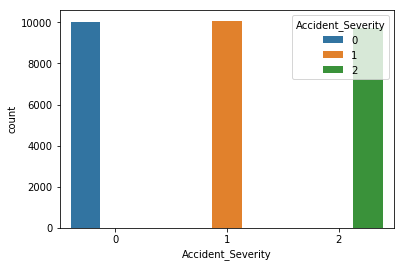

In [21]:
# 4.2 project the data
from pyspark.sql.functions import col

print (merged['Accident_Severity'].value_counts())
#sns.countplot('Accident_Severity',data=merged,hue='Accident_Severity')

df = spark.read.load("./dm1.csv",format="csv",header="true")

major_df = df.filter(col("Accident_Severity") == 2)
middle_df = df.filter(col("Accident_Severity") == 1)
minor_df = df.filter(col("Accident_Severity") == 0)

sampled_majority_df = major_df.sample(False, 10000/major_df.count())
sampled_middle_df = middle_df.sample(False, 10000/middle_df.count())
sampled_minor_df = minor_df.sample(True, 10000/minor_df.count())
combined_df_2 = sampled_majority_df.unionAll(sampled_minor_df)
combined_df_2 = combined_df_2.unionAll(sampled_middle_df)

combined_df = combined_df_2.toPandas()
print(combined_df['Accident_Severity'].value_counts())
sns.countplot('Accident_Severity',data=combined_df,hue='Accident_Severity')

# exported file has been in the repository
#combined_df.to_csv('./merge_sample1.csv',index=False)


In [2]:
# 7.1 logical test

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

merge_s = spark.read.load("./merge_sample1.csv",format="csv",header="true")
merge_s.columns

['Longitude',
 'Latitude',
 'Police_Force',
 'Accident_Severity',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Road_Type',
 'Speed_limit',
 'Junction_Detail',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Urban_or_Rural_Area',
 'Time_period',
 'Vehicle_Reference',
 'Casualty_Class',
 'Sex_of_Casualty',
 'Age_of_Casualty',
 'Pedestrian_Location',
 'Pedestrian_Movement',
 'Car_Passenger',
 'Bus_or_Coach_Passenger',
 'Casualty_Type']

In [3]:
assembler = VectorAssembler(
  inputCols=['Longitude',
 'Latitude',
 'Police_Force',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Road_Type',
 'Speed_limit',
 'Junction_Detail',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Urban_or_Rural_Area',
 'Time_period',
 'Vehicle_Reference',
 'Casualty_Class',
 'Sex_of_Casualty',
 'Age_of_Casualty',
 'Pedestrian_Location',
 'Pedestrian_Movement',
 'Car_Passenger',
 'Bus_or_Coach_Passenger',
 'Casualty_Type'],
              outputCol="features")


In [4]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer

for t in ['Longitude',
 'Latitude',
 'Police_Force',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Road_Type',
 'Speed_limit',
 'Junction_Detail',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Urban_or_Rural_Area',
 'Time_period',
 'Vehicle_Reference',
 'Casualty_Class',
 'Sex_of_Casualty',
 'Age_of_Casualty',
 'Pedestrian_Location',
 'Pedestrian_Movement',
 'Car_Passenger',
 'Bus_or_Coach_Passenger',
 'Casualty_Type']:
    merge_s = merge_s.withColumn(t, merge_s[t].cast(DoubleType()))

output = assembler.transform(merge_s)
indexer = StringIndexer(inputCol="Accident_Severity", outputCol="AccSeverityIndex")
output_fixed = indexer.fit(output).transform(output)
final_data = output_fixed.select("features",'AccSeverityIndex')
train_data,test_data = final_data.randomSplit([0.8,0.2])


In [5]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [6]:
dtc1 = DecisionTreeClassifier(labelCol='AccSeverityIndex',featuresCol='features',maxBins=100,impurity="gini")
dtc2 = DecisionTreeClassifier(labelCol='AccSeverityIndex',featuresCol='features',maxBins=100,impurity="entropy")
dtc3 = DecisionTreeClassifier(labelCol='AccSeverityIndex',featuresCol='features',maxBins=150,impurity="gini")
dtc4 = DecisionTreeClassifier(labelCol='AccSeverityIndex',featuresCol='features',maxBins=150,impurity="entropy")


rfc1 = RandomForestClassifier(labelCol='AccSeverityIndex',featuresCol='features',numTrees=100,impurity="gini")
rfc2 = RandomForestClassifier(labelCol='AccSeverityIndex',featuresCol='features',numTrees=100,impurity="entropy")
rfc3 = RandomForestClassifier(labelCol='AccSeverityIndex',featuresCol='features',numTrees=150,impurity="gini")
rfc4 = RandomForestClassifier(labelCol='AccSeverityIndex',featuresCol='features',numTrees=150,impurity="entropy")


In [7]:

dtc_model1 = dtc1.fit(train_data)
dtc_model2 = dtc2.fit(train_data)
dtc_model3 = dtc3.fit(train_data)
dtc_model4 = dtc4.fit(train_data)


rfc_model1 = rfc1.fit(train_data)
rfc_model2 = rfc2.fit(train_data)
rfc_model3 = rfc3.fit(train_data)
rfc_model4 = rfc4.fit(train_data)



In [8]:

dtc_predictions1 = dtc_model1.transform(test_data)
dtc_predictions2 = dtc_model2.transform(test_data)
dtc_predictions3 = dtc_model3.transform(test_data)
dtc_predictions4 = dtc_model4.transform(test_data)


rfc_predictions1 = rfc_model1.transform(test_data)
rfc_predictions2 = rfc_model2.transform(test_data)
rfc_predictions3 = rfc_model3.transform(test_data)
rfc_predictions4 = rfc_model4.transform(test_data)


In [9]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol='AccSeverityIndex',
                                                  predictionCol='prediction',metricName="accuracy")

dtc_acc1 = acc_evaluator.evaluate(dtc_predictions1)
dtc_acc2 = acc_evaluator.evaluate(dtc_predictions2)
dtc_acc3 = acc_evaluator.evaluate(dtc_predictions3)
dtc_acc4 = acc_evaluator.evaluate(dtc_predictions4)


rfc_acc1 = acc_evaluator.evaluate(rfc_predictions1)
rfc_acc2 = acc_evaluator.evaluate(rfc_predictions2)
rfc_acc3 = acc_evaluator.evaluate(rfc_predictions3)
rfc_acc4 = acc_evaluator.evaluate(rfc_predictions4)


print("Here are the results!")
print('-'*40)
print('A single decision tree(100,gini) has an accuracy of: {0:2.2f}%'.format(dtc_acc1*100))
print('A single decision tree(100,entropy) has an accuracy of: {0:2.2f}%'.format(dtc_acc2*100))
print('A single decision tree(150,gini) has an accuracy of: {0:2.2f}%'.format(dtc_acc3*100))
print('A single decision tree(150,entropy) has an accuracy of: {0:2.2f}%'.format(dtc_acc4*100))

print('-'*40)
print('A random forest ensemble(100,gini) has an accuracy of: {0:2.2f}%'.format(rfc_acc1*100))
print('A random forest ensemble(100,entropy) has an accuracy of: {0:2.2f}%'.format(rfc_acc2*100))
print('A random forest ensemble(150,gini) has an accuracy of: {0:2.2f}%'.format(rfc_acc3*100))
print('A random forest ensemble(150,entropy) has an accuracy of: {0:2.2f}%'.format(rfc_acc4*100))
print('-'*40)


Here are the results!
----------------------------------------
A single decision tree(100,gini) has an accuracy of: 53.01%
A single decision tree(100,entropy) has an accuracy of: 52.44%
A single decision tree(150,gini) has an accuracy of: 53.01%
A single decision tree(150,entropy) has an accuracy of: 52.44%
----------------------------------------
A random forest ensemble(100,gini) has an accuracy of: 54.49%
A random forest ensemble(100,entropy) has an accuracy of: 54.66%
A random forest ensemble(150,gini) has an accuracy of: 54.65%
A random forest ensemble(150,entropy) has an accuracy of: 54.16%
----------------------------------------


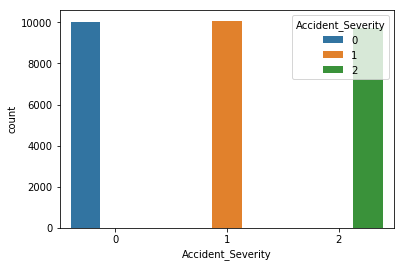

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

merged = pandas.read_csv("./merge_sample1.csv")

sns.countplot('Accident_Severity',data=merged,hue='Accident_Severity')


cols=[col for col in merged.columns if col not in ['Accident_Index','Accident_Severity']]
target = merged['Accident_Severity'].astype("category")
data = merged[cols]

data_train,data_test,target_train,target_test = train_test_split(data, target,test_size=0.2,random_state=1)


In [23]:
# neural network
from sklearn.neural_network import MLPClassifier

model_N1 = MLPClassifier(activation='relu')
model_N2 = MLPClassifier(activation='identity')
model_N3 = MLPClassifier(activation='logistic')
model_N4 = MLPClassifier(activation='tanh')

model_N1.fit(data_train, target_train)
model_N2.fit(data_train, target_train)
model_N3.fit(data_train, target_train)
model_N4.fit(data_train, target_train)
predict_model_N1 = model_N1.predict(data_test)
predict_model_N2 = model_N2.predict(data_test)
predict_model_N3 = model_N3.predict(data_test)
predict_model_N4 = model_N4.predict(data_test)

print("Neural_network accuracy(relu): ",accuracy_score(target_test,predict_model_N1))
print("Neural_network accuracy(identity): ",accuracy_score(target_test,predict_model_N2))
print("Neural_network accuracy(logistic): ",accuracy_score(target_test,predict_model_N3))
print("Neural_network accuracy(tanh): ",accuracy_score(target_test,predict_model_N4))



/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural_network accuracy(relu):  0.5574924572577942
Neural_network accuracy(identity):  0.488434461951056
Neural_network accuracy(logistic):  0.6040898424404961
Neural_network accuracy(tanh):  0.6180020113979215


/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [24]:
# knn 
from sklearn.neighbors import KNeighborsClassifier  

model_K1=KNeighborsClassifier()
model_K2=KNeighborsClassifier(n_neighbors=10)
model_K3=KNeighborsClassifier(n_neighbors=30)

model_K1.fit(data_train, target_train)
model_K2.fit(data_train, target_train)
model_K3.fit(data_train, target_train)
predict_model_K1 = model_K1.predict(data_test)
predict_model_K2 = model_K2.predict(data_test)
predict_model_K3 = model_K3.predict(data_test)
print("KNN accuracy(default): ",accuracy_score(target_test,predict_model_K1))
print("KNN accuracy(n_neighbors = 10): ",accuracy_score(target_test,predict_model_K2))
print("KNN accuracy(n_neighbors = 30): ",accuracy_score(target_test,predict_model_K3))


KNN accuracy(default):  0.4875283446712018
KNN accuracy(n_neighbors = 10):  0.47505668934240364
KNN accuracy(n_neighbors = 30):  0.48412698412698413


['Speed_limit', 'Casualty_Type', 'Age_of_Casualty', 'Number_of_Casualties', 'Junction_Detail', 'Urban_or_Rural_Area', 'Number_of_Vehicles', 'Light_Conditions', 'Police_Force', 'Vehicle_Reference', 'Sex_of_Casualty', 'Latitude', 'Casualty_Class', 'Pedestrian_Movement', 'Pedestrian_Location', 'Longitude', 'Road_Type', 'Time_period', 'Pedestrian_Crossing-Physical_Facilities', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Special_Conditions_at_Site', 'Road_Surface_Conditions', 'Weather_Conditions']


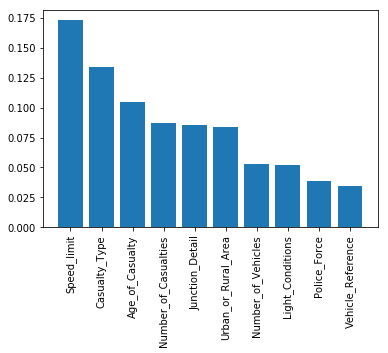

In [28]:
# feature importances
rfc_model1.featureImportances
columnHeader = ['Longitude',
 'Latitude',
 'Police_Force',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Road_Type',
 'Speed_limit',
 'Junction_Detail',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Urban_or_Rural_Area',
 'Time_period',
 'Vehicle_Reference',
 'Casualty_Class',
 'Sex_of_Casualty',
 'Age_of_Casualty',
 'Pedestrian_Location',
 'Pedestrian_Movement',
 'Car_Passenger',
 'Bus_or_Coach_Passenger',
 'Casualty_Type']
compare = []
for i in range(len(columnHeader)):
    compare +=[rfc_model1.featureImportances[i]]
compare_sort = compare[:]
compare_sort.sort(reverse=True)
ranking = []
for j in compare_sort:
    ranking += [columnHeader[compare.index(j)]]
print(ranking)

plt.bar(range(len(ranking[:10])), compare_sort[:10],tick_label=ranking[:10])
plt.xticks(range(len(ranking[:10])), ranking[:10], rotation=90)
plt.show()

In [12]:
# confusion matrix

df_pred = rfc_predictions1.select("prediction").toPandas()
df_test = test_data.select("AccSeverityIndex").toPandas()
print(confusion_matrix(df_test, df_pred))
print(classification_report(df_test, df_pred)) 


[[ 784  705  493]
 [ 328 1411  247]
 [ 544  372 1045]]
              precision    recall  f1-score   support

         0.0       0.47      0.40      0.43      1982
         1.0       0.57      0.71      0.63      1986
         2.0       0.59      0.53      0.56      1961

    accuracy                           0.55      5929
   macro avg       0.54      0.55      0.54      5929
weighted avg       0.54      0.55      0.54      5929

